In [1]:
!pip install h5py

In [2]:
pip install dask


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xarray h5netcdf h5py netcdf4



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopandas


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install rasterio


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


1. Data Extraction

In [6]:
# ==========================
# 1. Imports et SSL
# ==========================
import ssl
import os
import warnings
import pandas as pd
import xarray as xr
import earthaccess
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
%matplotlib inline



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# ==========================
# 2. Environment variables used for login
# ==========================
os.environ['EARTHDATA_USERNAME'] = 'tnourlyn'
os.environ['EARTHDATA_PASSWORD'] = 'Lutinette2411%'


In [8]:

# ==========================
# 3. EarthAccess authentification
# ==========================
try:
    auth = earthaccess.login(strategy="environment")
    print("✅ Authentification réussie !")
except Exception as e:
    print(f"❌ Échec de login : {e}")


✅ Authentification réussie !


In [9]:
# Deactivate SSL verification for Mac users 
import earthaccess, os

# Deactivate ssl in a fsspec session used by earthaccess
earthaccess.__store__.get_fsspec_session().kwargs['ssl'] = False
os.environ['FSSPEC_HTTP_VERIFY'] = 'False'

import certifi
import ssl
ssl_context = ssl.create_default_context(cafile=certifi.where())

In [10]:

# ==========================
# 4. Granules Search
# ==========================
minlon = 11.7 #Bouding box info for Nigeria -- To change depending on chosen country 
maxlon = 12.1
minlat = 13.0
maxlat = 13.4

#a granule contains the data for the bounding box for 1 month of a year 
granules = earthaccess.search_data(
    short_name='FLDAS_NOAH01_C_GL_M',
    temporal=("2020-01", "2024-12"),
    bounding_box=(minlon, minlat, maxlon, maxlat)
)
print(f"Granules found : {len(granules)}")


Granules found : 60


In [13]:

# ==========================
# 5. Data Opening # test for 1 year 
# ==========================

fn_list = earthaccess.open(granules)

ds_test = xr.open_dataset(fn_list[0], engine='h5netcdf') 
print(ds_test)


QUEUEING TASKS | : 100%|██████████| 60/60 [00:00<00:00, 5835.96it/s]
PROCESSING TASKS | : 100%|██████████| 60/60 [00:20<00:00,  2.96it/s]
COLLECTING RESULTS | : 100%|██████████| 60/60 [00:00<00:00, 195538.65it/s]


<xarray.Dataset> Size: 605MB
Dimensions:                 (time: 1, bnds: 2, Y: 1500, X: 3600)
Coordinates:
  * time                    (time) datetime64[ns] 8B 2020-01-01
  * Y                       (Y) float64 12kB -59.95 -59.85 ... 89.85 89.95
  * X                       (X) float64 29kB -179.9 -179.8 ... 179.9 180.0
Dimensions without coordinates: bnds
Data variables: (12/29)
    time_bnds               (time, bnds) datetime64[ns] 16B ...
    Evap_tavg               (time, Y, X) float32 22MB ...
    LWdown_f_tavg           (time, Y, X) float32 22MB ...
    Lwnet_tavg              (time, Y, X) float32 22MB ...
    Psurf_f_tavg            (time, Y, X) float32 22MB ...
    Qair_f_tavg             (time, Y, X) float32 22MB ...
    ...                      ...
    SoilMoi40_100cm_tavg    (time, Y, X) float32 22MB ...
    SoilMoi100_200cm_tavg   (time, Y, X) float32 22MB ...
    SoilTemp00_10cm_tavg    (time, Y, X) float32 22MB ...
    SoilTemp10_40cm_tavg    (time, Y, X) float32 22MB ...

We can open the first granule, containing all the data for january 2021, after several tests, we observe that it takes a long time to open all the data for 2020 to 2024 at once, we can thus use a loop 

In [ ]:
dfs = []


for fn in fn

In [16]:
def spatial_subset(ds):
    return ds.sel(
        X=slice(minlon, maxlon),
        Y=slice(minlat, maxlat)
    )

fn_list = earthaccess.open(granules)

#We use open_mfdataset because we have a list containing several datasets to open, each granule being a dataset. combine = "by_coords" allows to use the coordinates to assemble the dataframes since the granules contain data for the same coordinates but different months 
ds = xr.open_mfdataset( 
    fn_list,
    engine="h5netcdf",
    combine="by_coords",
    preprocess=spatial_subset,
    chunks={'time':1},
    parallel=False
)

print(ds)


QUEUEING TASKS | : 100%|██████████| 60/60 [00:00<00:00, 8109.11it/s]
PROCESSING TASKS | : 100%|██████████| 60/60 [00:21<00:00,  2.84it/s]
COLLECTING RESULTS | : 100%|██████████| 60/60 [00:00<00:00, 236298.82it/s]


<xarray.Dataset> Size: 109kB
Dimensions:                 (time: 60, bnds: 2, Y: 4, X: 4)
Coordinates:
  * time                    (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * Y                       (Y) float64 32B 13.05 13.15 13.25 13.35
  * X                       (X) float64 32B 11.75 11.85 11.95 12.05
Dimensions without coordinates: bnds
Data variables: (12/29)
    time_bnds               (time, bnds) datetime64[ns] 960B dask.array<chunksize=(1, 2), meta=np.ndarray>
    Evap_tavg               (time, Y, X) float32 4kB dask.array<chunksize=(1, 1, 4), meta=np.ndarray>
    LWdown_f_tavg           (time, Y, X) float32 4kB dask.array<chunksize=(1, 1, 4), meta=np.ndarray>
    Lwnet_tavg              (time, Y, X) float32 4kB dask.array<chunksize=(1, 1, 4), meta=np.ndarray>
    Psurf_f_tavg            (time, Y, X) float32 4kB dask.array<chunksize=(1, 1, 4), meta=np.ndarray>
    Qair_f_tavg             (time, Y, X) float32 4kB dask.array<chunksize=(1, 1, 4), meta=np.ndarray>
   

2. Dataframe creation

Let's create the data frame thanks to the extracted data 

In [18]:
#Let's create a list of variables : 
varNames =[
    'Evap_tavg',
    'LWdown_f_tavg',
    'Lwnet_tavg',
    'Psurf_f_tavg',
    'Qair_f_tavg',
    'Qg_tavg',
    'Qh_tavg',
    'Qle_tavg',
    'Qs_tavg',
    'Qsb_tavg',
    'RadT_tavg',
    'Rainf_f_tavg',
    'SWE_inst',
    'SWdown_f_tavg',
    'SnowCover_inst',
    'SnowDepth_inst',
    'Snowf_tavg',
    'Swnet_tavg',
    'Tair_f_tavg',
    'Wind_f_tavg',
    'SoilMoi00_10cm_tavg',
    'SoilMoi10_40cm_tavg',
    'SoilMoi40_100cm_tavg',
    'SoilMoi100_200cm_tavg',
    'SoilTemp00_10cm_tavg',
    'SoilTemp10_40cm_tavg',
    'SoilTemp40_100cm_tavg',
    'SoilTemp100_200cm_tavg'
]

In [19]:
#We select the variables within the bouding box:

ds_sel = ds[varNames].where(
    (ds.X >= minlon) & (ds.X <= maxlon) &
    (ds.Y >= minlat) & (ds.Y <= maxlat),
    drop=True 
)
df_NASA = ds_sel.to_dataframe().reset_index()



FSTimeoutError: 

In [ ]:
df_NASA.head()

,time,Y,X,Evap_tavg,LWdown_f_tavg,Lwnet_tavg,Psurf_f_tavg,Qair_f_tavg,Qg_tavg,Qh_tavg,...,Tair_f_tavg,Wind_f_tavg,SoilMoi00_10cm_tavg,SoilMoi10_40cm_tavg,SoilMoi40_100cm_tavg,SoilMoi100_200cm_tavg,SoilTemp00_10cm_tavg,SoilTemp10_40cm_tavg,SoilTemp40_100cm_tavg,SoilTemp100_200cm_tavg
0,2020-01-01,13.05,11.75,0.000004,301.766235,-114.224480,97730.023438,0.003047,-2.437553,36.012638,...,293.387177,8.211732,0.146190,0.280817,0.287616,0.316367,294.138306,294.960815,296.088745,297.725525
1,2020-01-01,13.05,11.85,0.000004,301.833221,-114.142052,97748.367188,0.003052,-2.515010,35.716026,...,293.406555,8.223705,0.146113,0.292110,0.299296,0.326776,294.156158,295.001312,296.138977,297.780273
2,2020-01-01,13.05,11.95,0.000004,301.819672,-114.200279,97717.820312,0.003048,-2.598254,35.661167,...,293.433441,8.227583,0.146031,0.307631,0.313970,0.336462,294.186920,295.054352,296.193878,297.826233
3,2020-01-01,13.05,12.05,0.000004,302.188110,-114.435616,97798.843750,0.003052,-2.563051,36.731537,...,293.535858,8.229089,0.145911,0.291901,0.298342,0.323498,294.303925,295.155914,296.303986,297.942688
4,2020-01-01,13.15,11.75,0.000004,301.254425,-114.119308,97715.625000,0.003028,-2.477718,36.182880,...,293.261108,8.256189,0.146109,0.271670,0.276233,0.297835,294.013611,294.844482,296.001343,297.675964


In [ ]:
df_NASA.isna().sum()

time                      0
Y                         0
X                         0
Evap_tavg                 0
LWdown_f_tavg             0
Lwnet_tavg                0
Psurf_f_tavg              0
Qair_f_tavg               0
Qg_tavg                   0
Qh_tavg                   0
Qle_tavg                  0
Qs_tavg                   0
Qsb_tavg                  0
RadT_tavg                 0
Rainf_f_tavg              0
SWE_inst                  0
SWdown_f_tavg             0
SnowCover_inst            0
SnowDepth_inst            0
Snowf_tavg                0
Swnet_tavg                0
Tair_f_tavg               0
Wind_f_tavg               0
SoilMoi00_10cm_tavg       0
SoilMoi10_40cm_tavg       0
SoilMoi40_100cm_tavg      0
SoilMoi100_200cm_tavg     0
SoilTemp00_10cm_tavg      0
SoilTemp10_40cm_tavg      0
SoilTemp40_100cm_tavg     0
SoilTemp100_200cm_tavg    0
dtype: int64

3. Spatial aggregation

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

admin2_gdf = gpd.read_file("gadm41_NGA_2.json")

#Convert pixels into Point geometries

gdf_pixels = gpd.GeoDataFrame(
    df_NASA, 
    geometry = gpd.points_from_xy(df_NASA['X'], df_NASA['Y']),
    crs = admin2_gdf.crs
)

gdf_pixels.head()
admin2_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
print(gdf_pixels.crs)
print(admin2_gdf.crs)

EPSG:4326
EPSG:4326


In [ ]:

gdf_joined = gpd.sjoin(
    gdf_pixels,
    admin2_gdf,
    how="left",
    predicate="within"
)

In [ ]:
print(df_NASA.shape)
print(gdf_joined.shape)

(16, 31)
(16, 46)


In [ ]:
print(gdf_joined.columns)

Index(['time', 'Y', 'X', 'Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg',
       'Psurf_f_tavg', 'Qair_f_tavg', 'Qg_tavg', 'Qh_tavg', 'Qle_tavg',
       'Qs_tavg', 'Qsb_tavg', 'RadT_tavg', 'Rainf_f_tavg', 'SWE_inst',
       'SWdown_f_tavg', 'SnowCover_inst', 'SnowDepth_inst', 'Snowf_tavg',
       'Swnet_tavg', 'Tair_f_tavg', 'Wind_f_tavg', 'SoilMoi00_10cm_tavg',
       'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg', 'SoilMoi100_200cm_tavg',
       'SoilTemp00_10cm_tavg', 'SoilTemp10_40cm_tavg', 'SoilTemp40_100cm_tavg',
       'SoilTemp100_200cm_tavg', 'geometry', 'index_right', 'GID_2', 'GID_0',
       'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2', 'VARNAME_2',
       'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2'],
      dtype='object')


In [ ]:
gdf_joined['NAME_2'].isna().value_counts()

NAME_2
False    9
True     7
Name: count, dtype: int64

In [ ]:
gdf_joined[gdf_joined['NAME_2'].isna()]

,time,Y,X,Evap_tavg,LWdown_f_tavg,Lwnet_tavg,Psurf_f_tavg,Qair_f_tavg,Qg_tavg,Qh_tavg,...,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
7,2020-01-01,13.15,12.05,0.000004,301.591675,-114.398567,97752.468750,0.003026,-2.590133,37.031712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2020-01-01,13.25,11.95,0.000004,300.986115,-114.116806,97736.382812,0.003007,-2.749410,36.367870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2020-01-01,13.25,12.05,0.000004,301.102081,-114.387520,97739.460938,0.003002,-2.684378,37.616776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,2020-01-01,13.35,11.75,0.000003,300.337402,-114.040031,97720.296875,0.002992,-2.345071,37.896351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2020-01-01,13.35,11.85,0.000003,300.477814,-114.040489,97746.257812,0.002991,-2.601868,37.544861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,2020-01-01,13.35,11.95,0.000004,300.647675,-114.159424,97770.304688,0.002987,-2.719135,37.648060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2020-01-01,13.35,12.05,0.000003,300.696808,-114.396065,97752.875000,0.002980,-2.725783,38.550518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


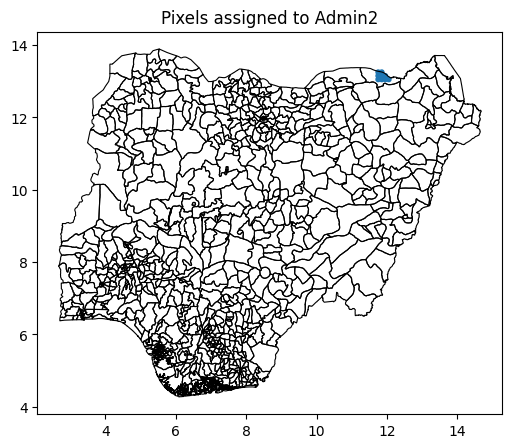

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

# Plot Admin2 boundaries
admin2_gdf.boundary.plot(ax=ax, linewidth=0.8, color="black")

# Plot pixels (sample only, for speed)
gdf_joined.plot(
    ax=ax,
    column="NAME_2",
    legend=False,
    markersize=10
)

plt.title("Pixels assigned to Admin2")
plt.show()

6. Converting the data into a CSV 

In [ ]:
df_NASA.to_csv(
    "FLDAS_Nigeria_pixels.csv",
    index=False
)

print("✅ df_NASA exported to FLDAS_Nigeria_pixels.csv")

✅ df_NASA exported to FLDAS_Nigeria_pixels.csv


In [ ]:
gdf_joined.to_csv(
    "geodata_FLDAS_Nigeria.csv",
    index= False
)

print("✅ gdf_joined exported to geodata_FLDAS_Nigeria.csv")


✅ gdf_joined exported to geodata_FLDAS_Nigeria.csv
